In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
from msbl import *

# 1) Double Well Potential

In [2]:
np.random.seed(1234)
def potential_double_well(x,delta_u,L):
    """"double well potential"""
    return delta_u*(-1 + (x/L)**2)**2

def force_double_well(x,delta_u, L):
    "double well drift force"
    return 4*delta_u*x/(L**2) - (4*delta_u*x**3)/L**4

#Set initial conditions
number_samples = 5000                               #total number of iterations
time_step = 0.2                                     #time step for euler differentation
L_stable = 0                                         #initial position
L =  5                                             #distance from the center to the minimum
H = 4                                               #height of the maximum
C1 = 4*H/(L**2)                                      #First coefficient of drift
C2 = -4*H/(L**4)                                     #Second coefficient diffusion

#Compute gaussian noise, time interval and trayectories
gaussian_noise = np.random.normal(size = number_samples)*np.sqrt(time_step)
trayectories_dw, time_values_dw = trayectories(L_stable, time_step, gaussian_noise, number_samples, 1, "double_well", L, H)

#generate library of functions for regression
lib_dw = library(trayectories_dw[:-1], 20)                    #Use polynomials up to order 20th for library
lib_dw = lib_dw.T

#generate expected value
Edr_dw = output_vectors_dr(trayectories_dw, time_step)          #Compute expectation value
Edr_dw = Edr_dw.reshape(len(Edr_dw), 1) 

CPU times: user 672 ms, sys: 12.3 ms, total: 684 ms
Wall time: 721 ms


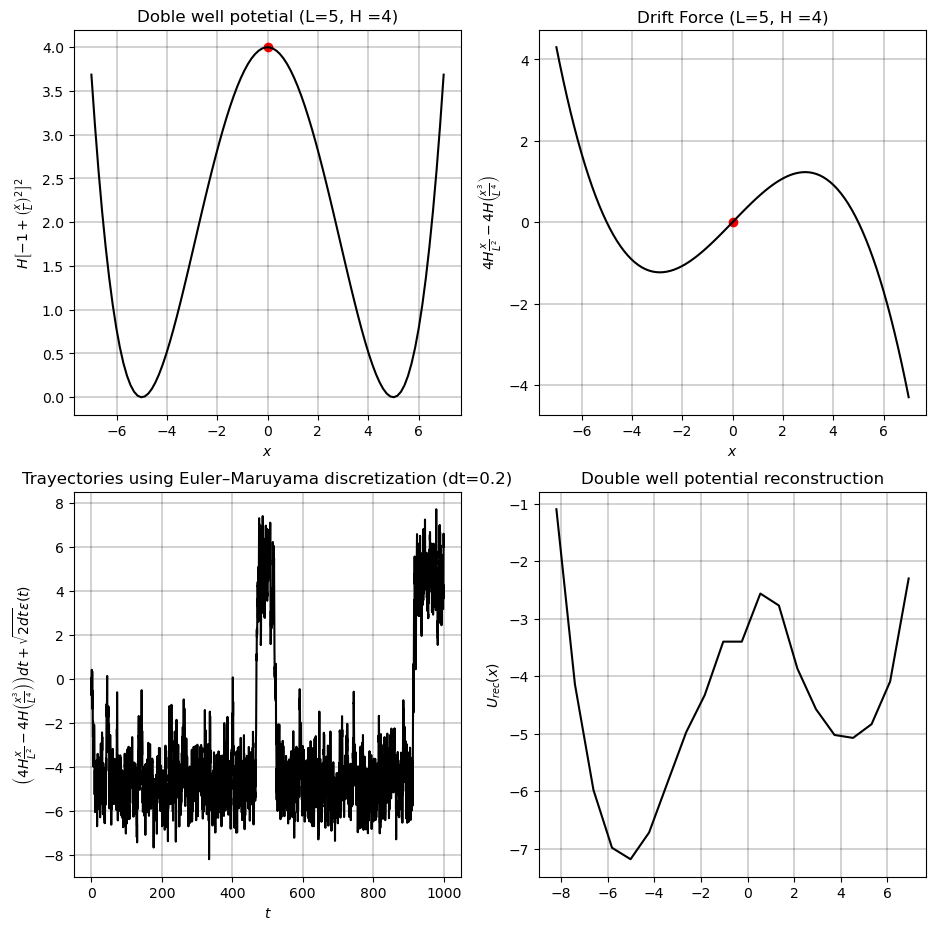

In [3]:
%%time
x_pot = np.linspace(-7,7,100)
#store histogram values
hist_values_dw = plt.hist(trayectories_dw, bins="doane")
hist_x_dw, hist_y_dw = hist_values_dw[0], hist_values_dw[1]
plt.close()

#Plottings
fig, axis = plt.subplots(2,2, figsize=(11,11))
axis[0,0].plot(x_pot, potential_double_well(x_pot, H, L), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,0].scatter(L_stable, potential_double_well(L_stable,H, L) , c = "r") 
axis[0,0].set_title("Doble well potetial (L={}, H ={})".format(L,H))
axis[0,0].set_ylabel(r"$H\left [ -1 +\left ( \frac{x}{L}\right)^{2} \right ]^{2}$")
axis[0,0].set_xlabel(r"$x$")
axis[0,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[0,1].plot(x_pot, force_double_well(x_pot, H, L), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,1].scatter(L_stable,force_double_well(L_stable,H, L) , c = "r") 
axis[0,1].set_title("Drift Force (L={}, H ={})".format(L,H))
axis[0,1].set_ylabel(r"$4H\frac{x}{L^{2}} - 4H\left ( \frac{x^{3}}{L^{4}} \right )$")
axis[0,1].set_xlabel(r"$x$")
axis[0,1].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,0].plot(time_values_dw, trayectories_dw, color ="k")
axis[1,0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
axis[1,0].set_ylabel(r"$\left (4H\frac{x}{L^{2}} - 4H\left ( \frac{x^{3}}{L^{4}} \right )  \right )dt + \sqrt{2dt}\varepsilon (t)$")
axis[1,0].set_xlabel(r"$t$")
axis[1,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,1].plot(hist_y_dw[:-1],-np.log(hist_x_dw), color = "k")
axis[1,1].set_title("Double well potential reconstruction")
axis[1,1].set_ylabel(r"$U_{rec}(x)$")
axis[1,1].grid(color='k', linestyle='-', linewidth=0.25)

In [4]:
#Compute drift and reject values below the threshold
sol_dr_dw =  msbl_pythonic(lib_dw, Edr_dw, 700)
threshold = 0.02                                                      
sol_dr_dw[abs(sol_dr_dw) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_dw = output_vectors_di(trayectories_dw, time_step, lib_dw, sol_dr_dw)
Edi_dw= Edi_dw.reshape(len(Edi_dw),1)
sol_di_dw=  msbl_pythonic(lib_dw, Edi_dw, 700)
sol_di_dw[abs(sol_di_dw) < threshold] = 0


In [5]:
#Compute L and H from results
C1_obt = sol_dr_dw[1]
C2_obt = sol_dr_dw[3]
D_ob = sol_di_dw[0]

def compute_L(A, B):
    return (-A/B)**(1/2)

def compute_H(A, B):
    return -(1/4)*(A**2/B)

H_obt = round(compute_H(C1_obt, C2_obt),3)
L_obt = round(compute_L(C1_obt, C2_obt),3)

#Compute error
error_L = abs(L-L_obt)/L_obt
error_H = abs(H-H_obt)/H_obt
error_Diff=abs(2-D_ob)/D_ob

print("The error for computing L is: {}".format(error_L*100), "and the accuracy for computing H is: {}".format(error_H*100))

The error for computing L is: 0.4419445560466099 and the accuracy for computing H is: 11.513799832729294


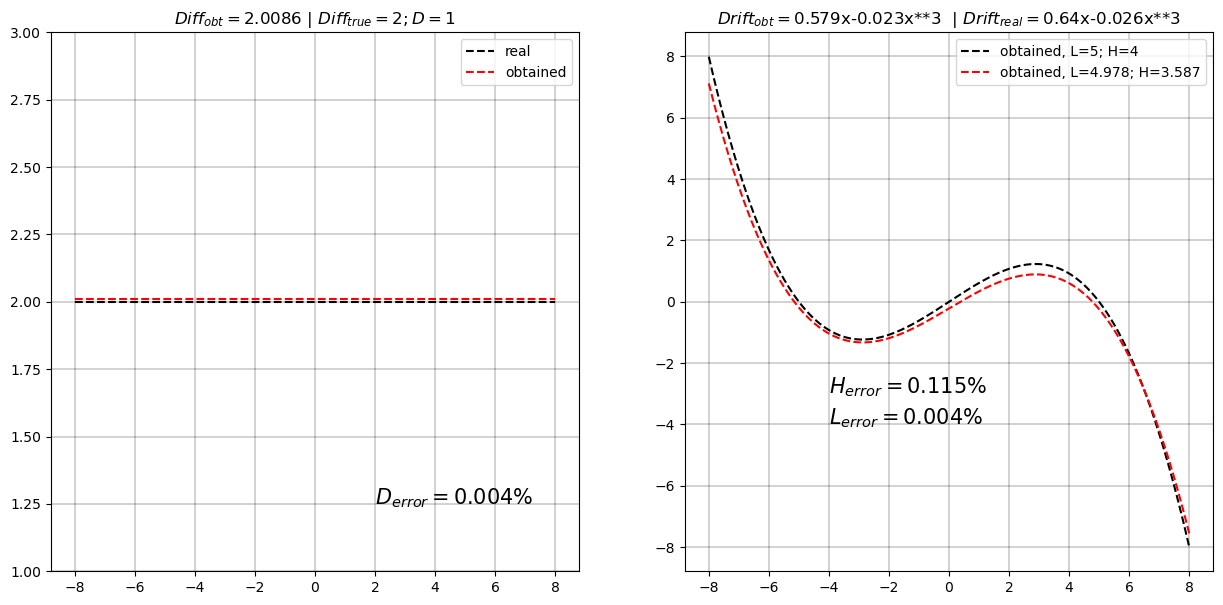

In [6]:
#recreate diffusion and drift equation using obtained coefficients from BISDE
test_pos_dw = np.linspace(-8,8,1000)
difussion_obtained_dw = plotting_results(test_pos_dw, sol_di_dw)
drift_obtained_dw = plotting_results(test_pos_dw, sol_dr_dw)
difussion_obtained_dw = np.sum(difussion_obtained_dw, axis =1 )
drift_obtained_dw= np.sum(drift_obtained_dw, axis =1 )

#set real diffusion and drift equation for later comparison
difussion_real_dw = plotting_results(test_pos_dw, [2,0,0])
drift_real_dw = plotting_results(test_pos_dw,[0,C1,0,C2])
difussion_real_dw = np.sum(difussion_real_dw, axis =1 )
drift_real_dw= np.sum(drift_real_dw, axis =1 )

#plot results
fig, axis = plt.subplots(1, 2, figsize =(15,7))
axis[0].plot(test_pos_dw, difussion_real_dw, label = "real", color ="k", linestyle="dashed")
axis[0].plot(test_pos_dw, difussion_obtained_dw,  label = "obtained", color ="r", linestyle="dashed")
axis[0].set_title(r"$Diff_{obt}=$"+str(round(sol_di_dw[0],4))+" | " + r"$Diff_{true}=$"+"2" +r"$ ; D=1$")
axis[0].set_ylim(1, 3)
axis[0].grid(color='k', linestyle='-', linewidth=0.25)
axis[0].annotate(r"$D_{error}=$" + str(round(error_Diff,3))+"%", xy = (2 , 1.25), size = 15)
axis[0].legend()

axis[1].plot(test_pos_dw, drift_real_dw, label = "obtained, L={}; H={}".format(L, H), color = "k", linestyle="dashed")
axis[1].plot(test_pos_dw, drift_obtained_dw , label = "obtained, L={}; H={}".format(L_obt, H_obt) , color ="r", linestyle="dashed")
axis[1].set_title(r"$Drift_{obt}=$"+str(round(sol_dr_dw[1],3))+"x"+str(round(sol_dr_dw[3],3))+"x**3 " +" | " + 
                  r"$Drift_{real}=$"+str(round(C1,3))+"x"+str(round(C2,3))+"x**3")
axis[1].grid(color='k', linestyle='-', linewidth=0.25)
axis[1].annotate(r"$L_{error}=$" + str(round(error_L,3))+"%", xy = (-4 , -4),size =15)
axis[1].annotate(r"$H_{error}=$" + str(round(error_H,3))+"%", xy = (-4 , -3), size = 15)

axis[1].legend()



# 2. HARMONIC POTENTIAL

In [7]:
# plot functions
def harmonic_potential(x,k):
    return (k*x**2)/2
def harmonic_force(x,k):
    return -k*x

#Set initial conditions
number_samples = 100000                                  #total number of iterations
time_step = 0.04                                         #time step for euler differentation
x_stable = 0                                             #initial position
k = 3                                                    #distance from the center to the minimum
gamma = 1                                                #frition coefficient


#Compute gaussian noise, time interval and trayectories
gaussian_noise = np.random.normal(size = number_samples)*np.sqrt(time_step)
trayectories_ha, time_values_ha = trayectories(x_stable, time_step, gaussian_noise, number_samples, 1, "harmonic_oscillator", k=k, gamma = gamma)

#generate library of functions for regression
lib_ha = library(trayectories_ha[:-1], 10)                    #Use polynomials up to order 20th for library
lib_ha = lib_ha.T

#generate expected value
Edr_ha = output_vectors_dr(trayectories_ha, time_step)          #Compute expectation value
Edr_ha = Edr_ha.reshape(len(Edr_ha), 1) 

In [8]:
k_samples = np.linspace(1,3,10)

In [9]:
#Create function that performs calculation for different values of k

def msbl_generator(n_samples, k_values):
    #Set initial conditions
    number_samples = 25000                                   #total number of iterations
    time_step = 0.04                                         #time step for euler differentation
    x_stable = 0                                             #initial position
    k_init = 3                                               #distance from the center to the minimum
    gamma = 1                                                #frition coefficient

    gaussian_noise = np.random.normal(size = number_samples)*np.sqrt(time_step)
    real_k = []
    estimated_k =[]
    real_D = []
    estimated_D =[]

    for kval in k_values:
        trayectories_ha, time_values_ha = trayectories(x_stable, time_step, gaussian_noise, number_samples, 1, "harmonic_oscillator", k=kval, gamma = gamma)
        
        lib_ha = library(trayectories_ha[:-1], 5)                    #Use polynomials up to order 20th for library
        lib_ha = lib_ha.T
        Edr_ha = output_vectors_dr(trayectories_ha, time_step)          #Compute expectation value
        Edr_ha = Edr_ha.reshape(len(Edr_ha), 1) 
        
        #Compute drift and reject values below the threshold
        sol_dr_ha =  msbl_pythonic(lib_ha, Edr_ha, 700)
        threshold = 0.05                                                      
        sol_dr_ha[abs(sol_dr_ha) < threshold] =0

        #Compute difussion using drift and reject values below the threshold
        Edi_ha = output_vectors_di(trayectories_ha, time_step, lib_ha, sol_dr_ha)
        Edi_ha= Edi_ha.reshape(len(Edi_ha),1)
        sol_di_ha=  msbl_pythonic(lib_ha, Edi_ha, 700)
        sol_di_ha[abs(sol_di_ha) < threshold] = 0

        real_k.append(kval)
        estimated_k.append(sol_dr_ha[1])
        real_D.append(2)
        estimated_D.append(sol_di_ha[0])

    return (real_k, estimated_k, real_D, estimated_D)


    

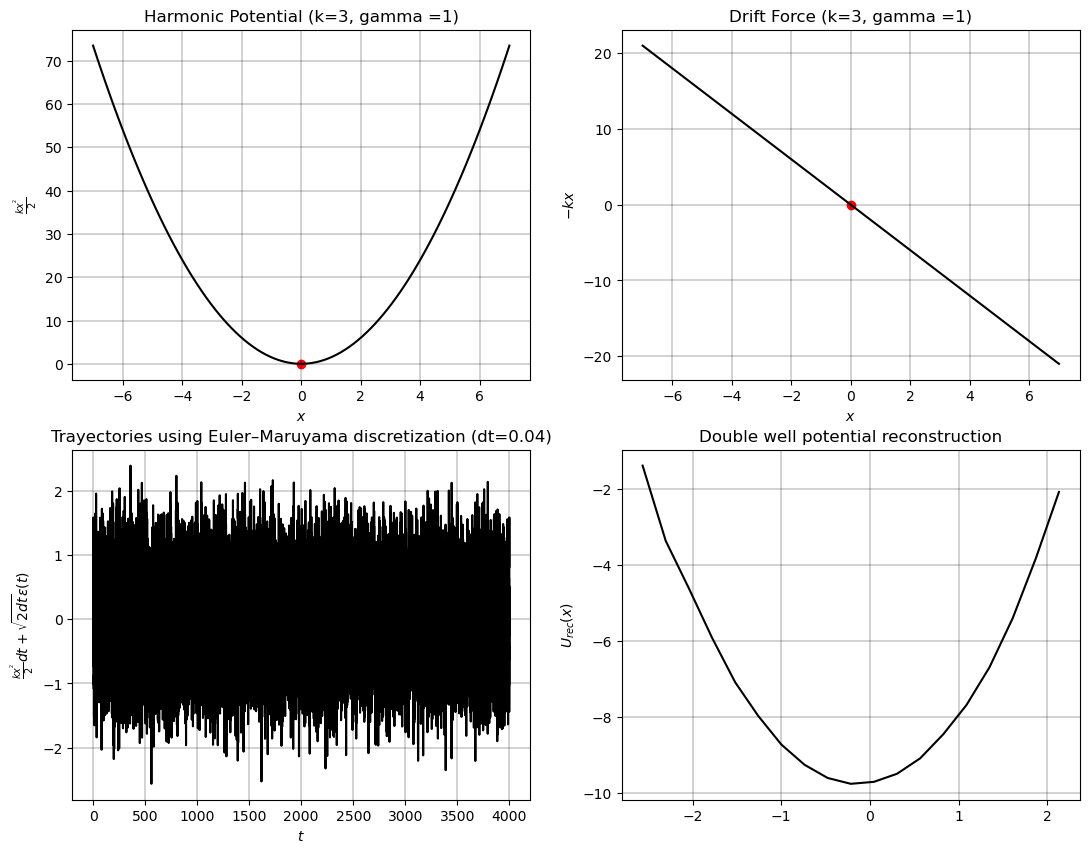

In [10]:
x_pot = np.linspace(-7,7,100)
#store histogram values
hist_values_ha = plt.hist(trayectories_ha, bins="doane")
hist_x_ha, hist_y_ha = hist_values_ha[0], hist_values_ha[1]
plt.close()

#Plottings
fig, axis = plt.subplots(2,2, figsize=(13,10))
axis[0,0].plot(x_pot, harmonic_potential(x_pot,k), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,0].scatter(x_stable, harmonic_potential(x_stable,k) , c = "r") 
axis[0,0].set_title("Harmonic Potential (k={}, gamma ={})".format(k,gamma))
axis[0,0].set_ylabel(r"$\frac{kx^{^{2}}}{2}$")
axis[0,0].set_xlabel(r"$x$")
axis[0,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[0,1].plot(x_pot, harmonic_force(x_pot,k), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,1].scatter(x_stable, harmonic_force(x_stable,k) , c = "r") 
axis[0,1].set_title("Drift Force (k={}, gamma ={})".format(k,gamma))
axis[0,1].set_ylabel(r"$-kx$")
axis[0,1].set_xlabel(r"$x$")
axis[0,1].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,0].plot(time_values_ha, trayectories_ha, color ="k")
axis[1,0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
axis[1,0].set_ylabel(r"$\frac{kx^{^{2}}}{2}dt + \sqrt{2dt}\varepsilon (t)$")
axis[1,0].set_xlabel(r"$t$")
axis[1,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,1].plot(hist_y_ha[:-1],-np.log(hist_x_ha), color = "k")
axis[1,1].set_title("Double well potential reconstruction")
axis[1,1].set_ylabel(r"$U_{rec}(x)$")
axis[1,1].grid(color='k', linestyle='-', linewidth=0.25)

In [11]:
#Compute drift and reject values below the threshold
sol_dr_ha =  msbl_pythonic(lib_ha, Edr_ha, 700)
threshold = 0.05                                                      
sol_dr_ha[abs(sol_dr_ha) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_ha = output_vectors_di(trayectories_ha, time_step, lib_ha, sol_dr_ha)
Edi_ha= Edi_ha.reshape(len(Edi_ha),1)
sol_di_ha=  msbl_pythonic(lib_ha, Edi_ha, 700)
sol_di_ha[abs(sol_di_ha) < threshold] = 0

In [12]:
#Compute L and H from results
k_obt = sol_dr_ha[1]
D_ob = sol_di_ha[0]

#Compute error
error_k = abs(k-abs(k_obt))/abs(k_obt)
error_Diff=abs(2-D_ob)/D_ob

print("The error for computing k is: {}".format(error_k*100), "and the error for computing Diff is: {}".format(error_Diff*100))

The error for computing k is: 0.3587557264985055 and the error for computing Diff is: 0.22904770996033347


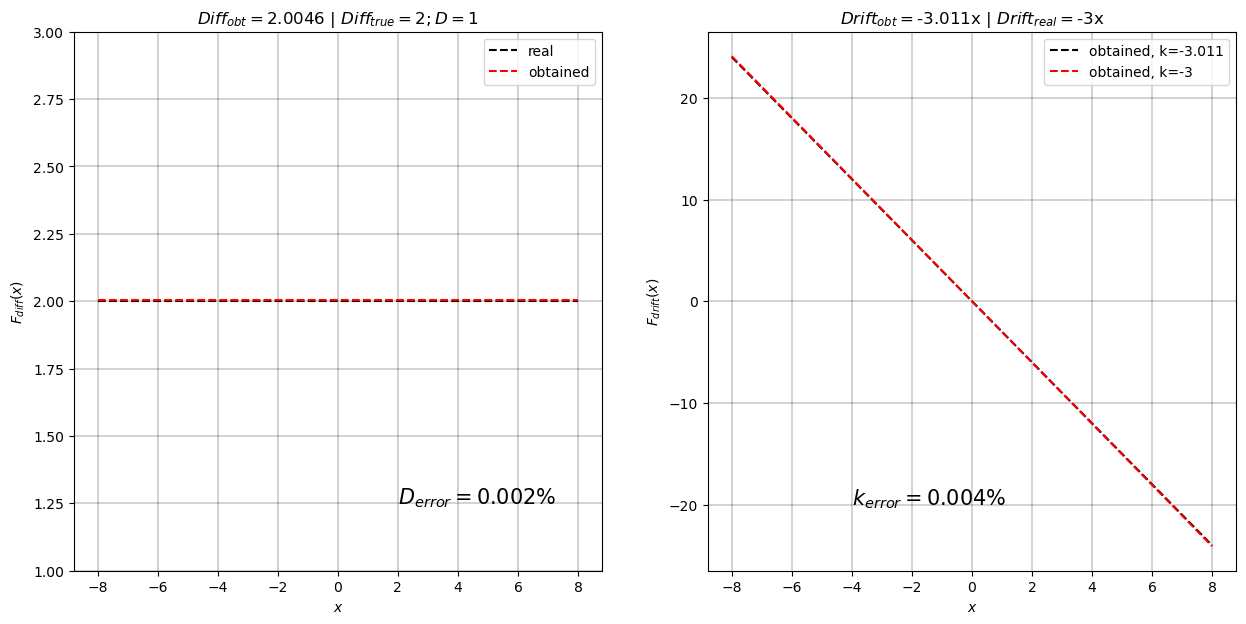

In [13]:
#recreate diffusion and drift equation using obtained coefficients from BISDE
test_pos_ha = np.linspace(-8,8,1000)
difussion_obtained_ha = plotting_results(test_pos_ha, sol_di_ha)
drift_obtained_ha = plotting_results(test_pos_ha, sol_dr_ha)
difussion_obtained_ha = np.sum(difussion_obtained_ha, axis =1 )
drift_obtained_ha= np.sum(drift_obtained_ha, axis =1 )

#set real diffusion and drift equation for later comparison
difussion_real_ha = plotting_results(test_pos_ha, [2,0,0])
drift_real_ha = plotting_results(test_pos_ha,[0,-k/gamma])
difussion_real_ha = np.sum(difussion_real_ha, axis =1 )
drift_real_ha= np.sum(drift_real_ha, axis =1 )

#plot results
fig, axis = plt.subplots(1, 2, figsize =(15,7))
axis[0].plot(test_pos_ha, difussion_real_ha, label = "real", color ="k", linestyle="dashed")
axis[0].plot(test_pos_ha, difussion_obtained_ha,  label = "obtained", color ="r", linestyle="dashed")
axis[0].set_title(r"$Diff_{obt}=$"+str(round(sol_di_ha[0],4))+" | " + r"$Diff_{true}=$"+"2" +r"$ ; D=1$")
axis[0].set_ylim(1, 3)
axis[0].grid(color='k', linestyle='-', linewidth=0.25)
axis[0].annotate(r"$D_{error}=$" + str(round(error_Diff,3))+"%", xy = (2 , 1.25), size = 15)
axis[0].set_xlabel(r"$x$")
axis[0].set_ylabel(r"$F_{diff}(x)$")

axis[0].legend()

axis[1].plot(test_pos_ha, drift_real_ha, label = "obtained, k={}".format(round(k_obt, 3)), color = "k", linestyle="dashed")
axis[1].plot(test_pos_ha, drift_obtained_ha , label = "obtained, k={}".format(-k) , color ="r", linestyle="dashed")
axis[1].set_title(r"$Drift_{obt}=$"+str(round(sol_dr_ha[1],3))+"x" +" | " + 
                  r"$Drift_{real}=$"+str(round(-k,3))+"x")
axis[1].grid(color='k', linestyle='-', linewidth=0.25)
axis[1].annotate(r"$k_{error}=$" + str(round(error_k,3))+"%", xy = (-4 , -20),size =15)
axis[1].set_xlabel(r"$x$")
axis[1].set_ylabel(r"$F_{drift}(x)$")
axis[1].legend()



# 3. 2D Case

In [14]:
#Set initial conditions
number_samples = 8*10**4                   #total number of iterations
time_step = 0.025                                     #time step for euler differentation
xy_init = [1,1]                                        #initial position


#Compute gaussian noise, time interval and trayectories
gaussian_noise_2d = np.random.normal(size = number_samples)*np.sqrt(time_step), np.random.normal(size = number_samples)*np.sqrt(time_step)
trayectories_x_2d, trayectories_y_2d, time_values_2d = trayectories_2d(xy_init, time_step, gaussian_noise_2d, number_samples)

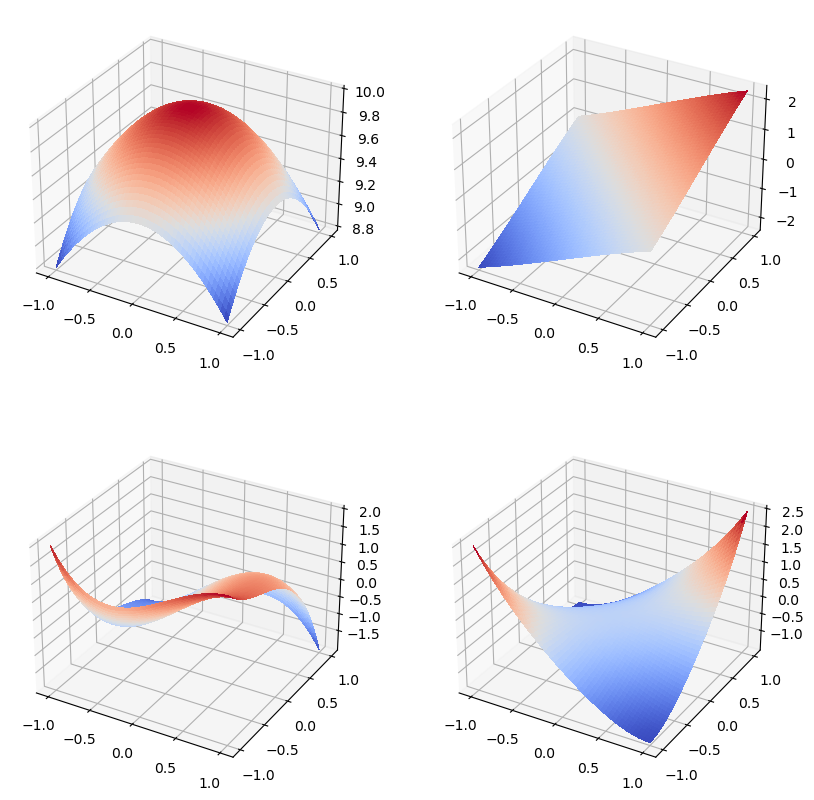

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(10,10))

# Make data.
X = np.arange(-1, 1, 0.001)
Y = np.arange(-1, 1, 0.001)
X, Y = np.meshgrid(X, Y)
Z = potential_double_well(X,5,4) +potential_double_well(Y,5,4) 


# Plot the surface.
ax[0][0].plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax[0][1].plot_surface(X, Y,force_double_well(X,5,4) + force_double_well(Y,5,4) , cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax[1][0].plot_surface(X,Y, drift_x(X,Y) + drift_y(X,Y),  cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax[1][1].plot_surface(X,Y, -pot_x(X,Y) - pot_y(X,Y),  cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

In [ ]:
for angle in range(0, 360):
    ax[0][0].view_init(30, angle)
    plt.draw()
    plt.pause(.001)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

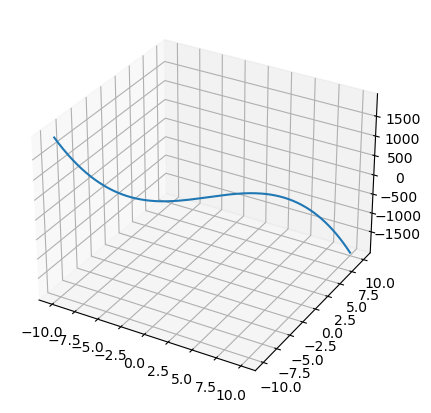

In [ ]:
from matplotlib import cm
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.plot3D(np.linspace(-10,10,1000), np.linspace(-10,10,1000), drift_y(np.linspace(-10,10,1000),np.linspace(-10,10,1000)))

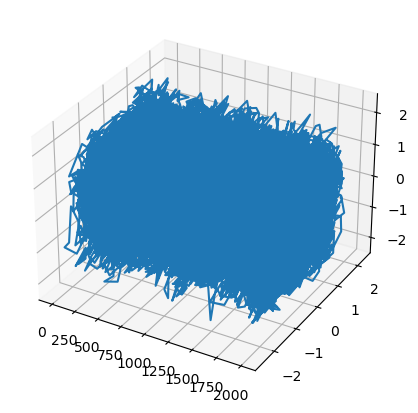

In [ ]:
from matplotlib import cm
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.plot3D(time_values_2d, trayectories_x_2d, trayectories_y_2d)

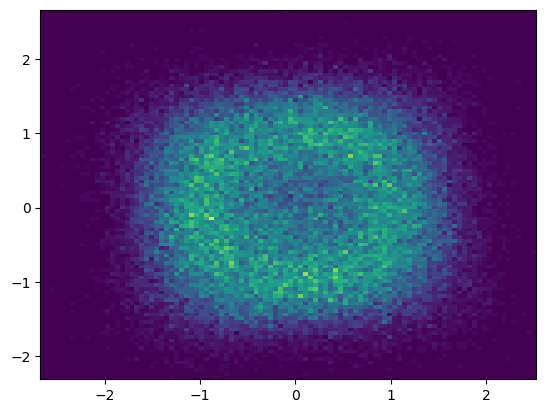

In [ ]:
A = plt.hist2d(trayectories_x_2d, trayectories_y_2d, bins=(100,100))

In [ ]:
len(A[0])

100

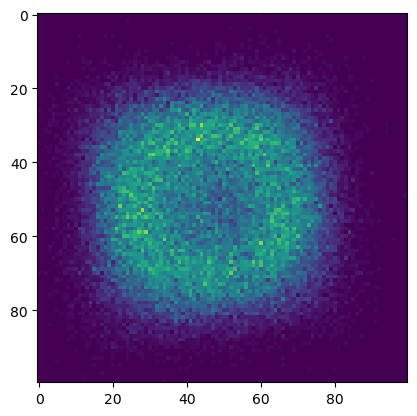

In [ ]:
plt.imshow(A[0])

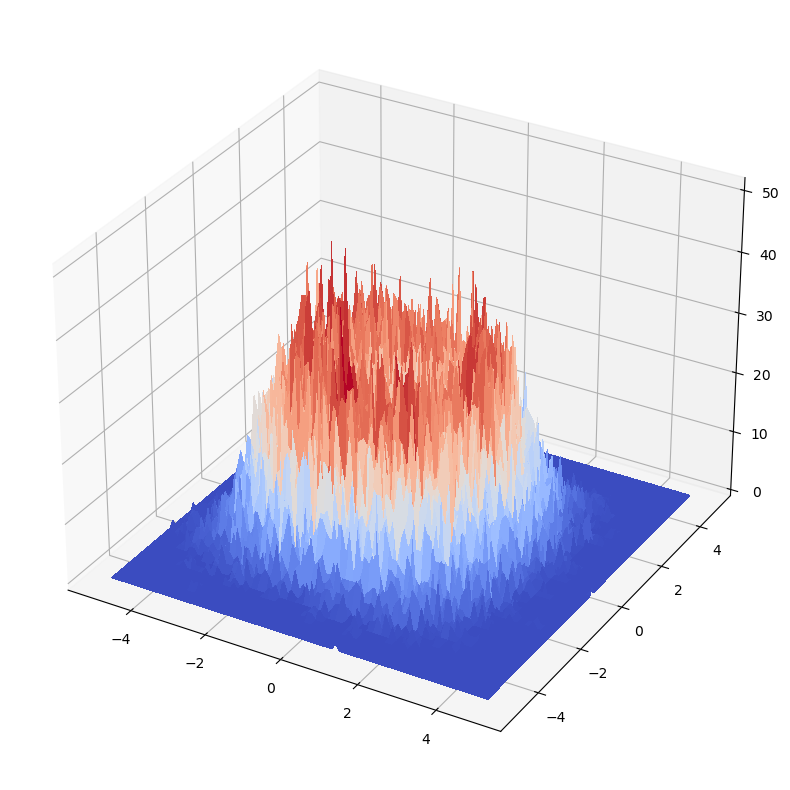

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = potential_double_well(X,5,4) +potential_double_well(Y,5,4) 


# Plot the surface.
ax.plot_surface(X, Y, A[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


In [ ]:
#generate library of functions for regression
lib_2d, indexes_2d = library2d(trayectories_x_2d[:-1],trayectories_y_2d[:-1], 4)                    
lib_2d = lib_2d.T
label=["1", "y", "y**2", "y**3", "x", "xy", "xy**2", "xy**3", "x**2", "x**2y",
       "x**2y**2", "x**2y**3", "x**3", "x**3y", "x**3y**2", "x**3y**3"]

#generate expectation values
Edr_2dx = output_vectors_dr(trayectories_x_2d, time_step)          
Edr_2dx = Edr_2dx.reshape(len(Edr_2dx), 1) 
Edr_2dy = output_vectors_dr(trayectories_y_2d, time_step)          
Edr_2dy = Edr_2dy.reshape(len(Edr_2dy), 1) 

In [ ]:
#Compute drift and reject values below the threshold
sol_dr_2dx =  msbl_pythonic(lib_2d, Edr_2dx, 700)
threshold = 0.1                                                      
sol_dr_2dx[abs(sol_dr_2dx) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_2dx = output_vectors_di(trayectories_x_2d, time_step, lib_2d, sol_dr_2dx)
Edi_2dx= Edi_2dx.reshape(len(Edi_2dx),1)
sol_di_2dx=  msbl_pythonic(lib_2d, Edi_2dx, 1000)
sol_di_2dx[abs(sol_di_2dx) < threshold] = 0

#Compute drift and reject values below the threshold
sol_dr_2dy =  msbl_pythonic(lib_2d, Edr_2dy, 1000)
threshold = 0.1                                                     
sol_dr_2dy[abs(sol_dr_2dy) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_2dy = output_vectors_di(trayectories_y_2d, time_step, lib_2d, sol_dr_2dy)
Edi_2dy= Edi_2dy.reshape(len(Edi_2dy),1)
sol_di_2dy=  msbl_pythonic(lib_2d, Edi_2dy, 1000)
sol_di_2dy[abs(sol_di_2dy) < threshold] = 0

In [ ]:
sol_di_2dx

array([0.993827  , 0.        , 1.01130853, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [ ]:
#Compute drift x errors
C1 = sol_dr_2dx[1]
C4 = sol_dr_2dx[4]
C6 = sol_dr_2dx[6]
C12 = sol_dr_2dx[12]
C1_r = -1
C4_r= 1
C6_r = -1
C12_r = -1
#Compute error
error_C1 = abs((C1_r-C1)/C1)
error_C4 = abs((C4_r-C4)/C4)
error_C6 = abs((C6_r-C6)/C6)
error_C12 = abs((C12_r-C12)/C12)

#Compute difF x errors
D0 = sol_di_2dx[0]
D2 = sol_di_2dx[2]
D0_r = 1
D2_r= 1

#Compute error
error_C1 = abs((C1_r-C1)/C1)
error_C4 = abs((C4_r-C4)/C4)
error_C6 = abs((C6_r-C6)/C6)
error_C12 = abs((C12_r-C12)/C12)
error_D0 = abs((D0_r-D0)/D0)
error_D2 = abs((D2_r-D2)/D2)


print("The error for computing the coefficients of the drift x are: C1={}, C4={}, C6={}, C12={}".format(error_C1*100,error_C4*100, error_C6*100, error_C12*100 ))
print("The error for computing the coefficients of the diffusion x are: D0={}, D2={}".format(error_D0*100,error_D2*100))

The error for computing the coefficients of the drift x are: C1=8.792242680907272, C4=3.2141866942063517, C6=19.207898909822635, C12=0.80815056584575
The error for computing the coefficients of the diffusion x are: D0=0.6211342269083576, D2=1.1182077262325083


In [ ]:
#Compute drift x errors
A1 = sol_dr_2dy[1]
A3 = sol_dr_2dy[3]
A4 = sol_dr_2dy[4]
A9 = sol_dr_2dy[9]
A1_r = 1
A3_r= -1
A4_r = 1
A9_r = -1
#Compute error
error_A1 = abs((A1_r-A1)/A1)
error_A3 = abs((A4_r-A3)/A3)
error_A4 = abs((A4_r-A4)/A4)
error_A9 = abs((A9_r-A9)/A9)

#Compute difF x errors
B0 = sol_di_2dy[0]
B8 = sol_di_2dy[8]
B0_r = 1
B8_r= 1

#Compute error
error_A1 = abs((A1_r-A1)/A1)
error_A3 = abs((A3_r-A3)/A3)
error_A4 = abs((A4_r-A4)/A4)
error_A9 = abs((A9_r-A9)/A9)
error_B0 = abs((B0_r-B0)/B0)
error_B8 = abs((B8_r-B8)/B8)


print("The error for computing the coefficients of the drift x are: A1={}, A3={}, A4={}, A9={}".format(error_A1*100,error_A3*100, error_A4*100, error_A9*100 ))
print("The error for computing the coefficients of the diffusion x are: B0={}, B8={}".format(error_B0*100,error_B8*100))

The error for computing the coefficients of the drift x are: A1=5.5990022283287715, A3=2.744542782947131, A4=3.1595626970698945, A9=1.2351064976223851
The error for computing the coefficients of the diffusion x are: B0=0.738484297152569, B8=0.43540999167688


In [ ]:
def plotting_2d(indexes, array, pos_x, pos_y):
    plot = np.zeros((len(pos_x), len(array)))
    indexes_x = indexes[0]
    indexes_y = indexes[1]
    for i in range(0,len(array)):
        if array[i]!=0:
            for k in range(0,len(pos_x)):
                plot[k,i] = array[i]*(pos_x[k]**indexes_x[i])*(pos_y[k]**indexes_y[i])

    return(plot)


In [ ]:
test_pos_2d = np.linspace(-8,8,1000)
difussion_obtained_2dx = plotting_2d(indexes_2d, sol_di_2dx, test_pos_2d, test_pos_2d)
drift_obtained_2dx = plotting_2d(indexes_2d, sol_dr_2dx, test_pos_2d, test_pos_2d)
difussion_obtained_2dx = np.sum(difussion_obtained_2dx, axis =1 )
drift_obtained_2dx= np.sum(drift_obtained_2dx, axis =1 )
drift_real_2dx = test_pos_2d -test_pos_2d**3 - test_pos_2d*test_pos_2d**2 - test_pos_2d
diffusion_real_2dx = 1 + test_pos_2d**2

difussion_obtained_2dy = plotting_2d(indexes_2d, sol_di_2dy, test_pos_2d, test_pos_2d)
drift_obtained_2dy = plotting_2d(indexes_2d, sol_dr_2dy, test_pos_2d, test_pos_2d)
difussion_obtained_2dy = np.sum(difussion_obtained_2dy, axis =1 )
drift_obtained_2dy= np.sum(drift_obtained_2dy, axis =1 )
drift_real_2dy = test_pos_2d -test_pos_2d**3 - test_pos_2d*test_pos_2d**2 + test_pos_2d
diffusion_real_2dy = 1 + test_pos_2d**2

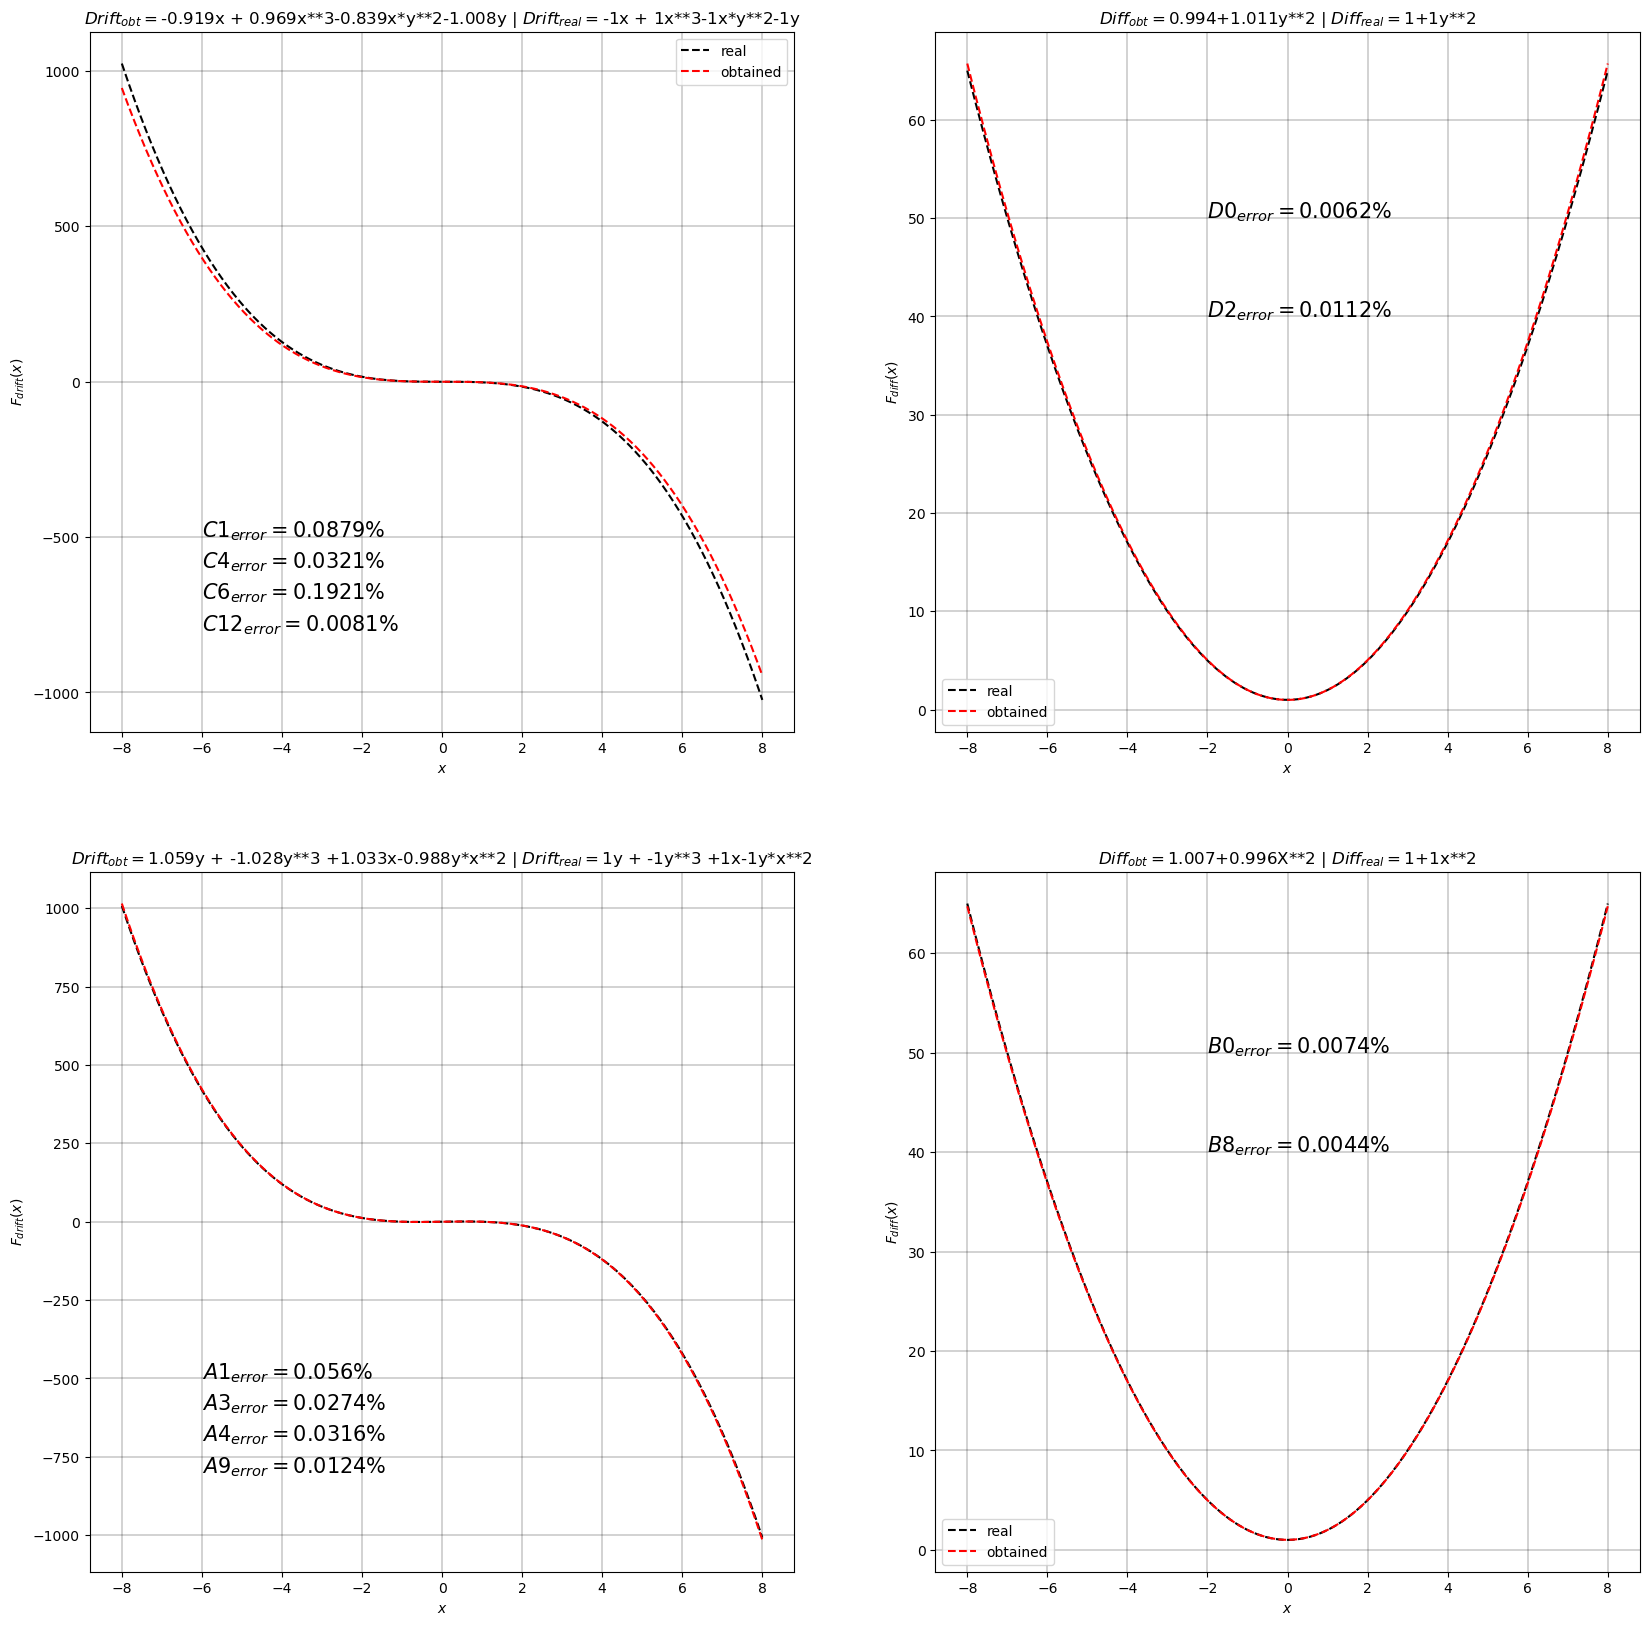

In [ ]:
#plot results
fig, axis = plt.subplots(2, 2, figsize =(20,20))
axis[0][0].plot(test_pos_2d, drift_real_2dx, label = "real", color ="k", linestyle="dashed")
axis[0][0].plot(test_pos_2d, drift_obtained_2dx,  label = "obtained", color ="r", linestyle="dashed")
axis[0][0].set_title(r"$Drift_{obt}=$"+str(round(C1,3))+"x + " +str(round(C4,3))+"x**3" + str(round(C6,3))+"x*y**2" + str(round(C12,3))+"y" + " | "
                  r"$Drift_{real}=$"+str(round(C1_r,3))+"x + " +str(round(C4_r,3))+"x**3" + str(round(C6_r,3))+"x*y**2" + str(round(C12_r,3))+"y")
axis[0][0].grid(color='k', linestyle='-', linewidth=0.25)
axis[0][0].annotate(r"$C1_{error}=$" + str(round(error_C1,4))+"%", xy = (-6 , -500),size =15)
axis[0][0].annotate(r"$C4_{error}=$" + str(round(error_C4,4))+"%", xy = (-6 , -600),size =15)
axis[0][0].annotate(r"$C6_{error}=$" + str(round(error_C6,4))+"%", xy = (-6 , -700),size =15)
axis[0][0].annotate(r"$C12_{error}=$" + str(round(error_C12,4))+"%", xy = (-6 , -800),size =15)
axis[0][0].set_xlabel(r"$x$")
axis[0][0].set_ylabel(r"$F_{drift}(x)$")

axis[0][0].legend()

axis[0][1].plot(test_pos_2d, diffusion_real_2dx, label = "real", color = "k", linestyle="dashed")
axis[0][1].plot(test_pos_2d, difussion_obtained_2dx , label = "obtained" , color ="r", linestyle="dashed")
axis[0][1].set_title(r"$Diff_{obt}=$"+str(round(D0,3))+"+"+str(round(D2,3)) +"y**2 | " + 
                  r"$Diff_{real}=$"+str(D0_r)+"+"+str(D2_r) +"y**2")
axis[0][1].grid(color='k', linestyle='-', linewidth=0.25)
axis[0][1].annotate(r"$D0_{error}=$" + str(round(error_D0,4))+"%", xy = (-2 , 50),size =15)
axis[0][1].annotate(r"$D2_{error}=$" + str(round(error_D2,4))+"%", xy = (-2 , 40),size =15)
axis[0][1].set_xlabel(r"$x$")
axis[0][1].set_ylabel(r"$F_{diff}(x)$")
axis[0][1].legend()

axis[1][0].plot(test_pos_2d, drift_real_2dy, label = "real", color ="k", linestyle="dashed")
axis[1][0].plot(test_pos_2d, drift_obtained_2dy,  label = "obtained", color ="r", linestyle="dashed")
axis[1][0].set_title(r"$Drift_{obt}=$"+str(round(A1,3))+"y + " +str(round(A3,3))+"y**3 +" + str(round(A4,3))+"x" + str(round(A9,3))+"y*x**2" + " | "
                  r"$Drift_{real}=$"+str(round(A1_r,3))+"y + " +str(round(A3_r,3))+"y**3 +" + str(round(A4_r,3))+"x" + str(round(A9_r,3))+"y*x**2")
axis[1][0].grid(color='k', linestyle='-', linewidth=0.25)
axis[1][0].annotate(r"$A1_{error}=$" + str(round(error_A1,4))+"%", xy = (-6 , -500),size =15)
axis[1][0].annotate(r"$A3_{error}=$" + str(round(error_A3,4))+"%", xy = (-6 , -600),size =15)
axis[1][0].annotate(r"$A4_{error}=$" + str(round(error_A4,4))+"%", xy = (-6 , -700),size =15)
axis[1][0].annotate(r"$A9_{error}=$" + str(round(error_A9,4))+"%", xy = (-6 , -800),size =15)
axis[1][0].set_xlabel(r"$x$")
axis[1][0].set_ylabel(r"$F_{drift}(x)$")


axis[1][1].plot(test_pos_2d, diffusion_real_2dy, label = "real", color = "k", linestyle="dashed")
axis[1][1].plot(test_pos_2d, difussion_obtained_2dy , label = "obtained" , color ="r", linestyle="dashed")
axis[1][1].set_title(r"$Diff_{obt}=$"+str(round(B0,3))+"+"+str(round(B8,3)) +"X**2 | " + 
                  r"$Diff_{real}=$"+str(B0_r)+"+"+str(B8_r) +"x**2")
axis[1][1].grid(color='k', linestyle='-', linewidth=0.25)
axis[1][1].annotate(r"$B0_{error}=$" + str(round(error_B0,4))+"%", xy = (-2 , 50),size =15)
axis[1][1].annotate(r"$B8_{error}=$" + str(round(error_B8,4))+"%", xy = (-2 , 40),size =15)
axis[1][1].set_xlabel(r"$x$")
axis[1][1].set_ylabel(r"$F_{diff}(x)$")
axis[1][1].legend()